# Stock Price Predictor using LSTM Neural Networks
**Author:** tihassfjord  
**GitHub:** github.com/tihassfjord

This project implements a time series forecasting model for stock prices using LSTM neural networks with technical indicators and multiple timeframe analysis.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Try to import PyTorch libraries, fallback to basic implementation if not available
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    ADVANCED_MODE = True
    print("✅ PyTorch available - Using LSTM neural networks")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 Using device: {device}")
except ImportError:
    ADVANCED_MODE = False
    device = 'cpu'
    print("⚠️ PyTorch not available - Using simplified linear model")

print(f"Advanced Mode: {ADVANCED_MODE}")

✅ PyTorch available - Using LSTM neural networks
📱 Using device: cuda
Advanced Mode: True


## Stock Price Predictor Class

The main class that handles data generation, feature engineering, model training, and predictions using PyTorch.

In [3]:
class LSTMModel(nn.Module):
    """
    PyTorch LSTM model for stock price prediction
    """
    def __init__(self, input_size, hidden_size=50, num_layers=3, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout_rate)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the last output
        out = out[:, -1, :]
        
        # Fully connected layers
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

class StockPricePredictor:
    """
    A comprehensive stock price prediction system using PyTorch LSTM neural networks
    with technical indicators and feature engineering.
    """
    
    def __init__(self, lookback_days=60, prediction_days=7):
        """
        Initialize the Stock Price Predictor
        
        Args:
            lookback_days (int): Number of historical days to use for prediction
            prediction_days (int): Number of days to predict into the future
        """
        self.lookback_days = lookback_days
        self.prediction_days = prediction_days
        self.scaler = MinMaxScaler()
        self.model = None
        self.feature_columns = []
        self.device = device if ADVANCED_MODE else 'cpu'
        
    def generate_synthetic_stock_data(self, days=1000, symbol="TECH"):
        """
        Generate realistic synthetic stock data with technical patterns
        
        Args:
            days (int): Number of days to generate
            symbol (str): Stock symbol name
            
        Returns:
            pd.DataFrame: Stock data with OHLCV columns
        """
        np.random.seed(42)
        
        # Base price parameters
        initial_price = 100
        trend = 0.0003  # Slight upward trend
        volatility = 0.02
        
        # Generate price movements with realistic patterns
        dates = pd.date_range(start='2020-01-01', periods=days, freq='D')
        
        # Generate realistic price movements
        returns = np.random.normal(trend, volatility, days)
        
        # Add some market events (crashes and rallies)
        crash_points = np.random.choice(days, size=3, replace=False)
        rally_points = np.random.choice(days, size=5, replace=False)
        
        for point in crash_points:
            returns[point:point+5] = np.random.normal(-0.05, 0.01, 5)
        
        for point in rally_points:
            returns[point:point+3] = np.random.normal(0.03, 0.01, 3)
        
        # Calculate cumulative prices
        price_multipliers = np.cumprod(1 + returns)
        close_prices = initial_price * price_multipliers
        
        # Generate OHLC data
        high_prices = close_prices * (1 + np.abs(np.random.normal(0, 0.01, days)))
        low_prices = close_prices * (1 - np.abs(np.random.normal(0, 0.01, days)))
        
        # Ensure OHLC consistency
        open_prices = np.zeros(days)
        open_prices[0] = initial_price
        for i in range(1, days):
            open_prices[i] = close_prices[i-1] + np.random.normal(0, 0.005) * close_prices[i-1]
        
        # Ensure High >= max(Open, Close) and Low <= min(Open, Close)
        for i in range(days):
            high_prices[i] = max(high_prices[i], open_prices[i], close_prices[i])
            low_prices[i] = min(low_prices[i], open_prices[i], close_prices[i])
        
        # Generate volume (higher volume on significant price movements)
        base_volume = 1000000
        volume_multiplier = 1 + np.abs(returns) * 5
        volumes = np.random.normal(base_volume, base_volume * 0.3, days) * volume_multiplier
        volumes = np.maximum(volumes, 100000)  # Minimum volume
        
        # Create DataFrame
        stock_data = pd.DataFrame({
            'Date': dates,
            'Open': open_prices,
            'High': high_prices,
            'Low': low_prices,
            'Close': close_prices,
            'Volume': volumes.astype(int),
            'Symbol': symbol
        })
        
        return stock_data

## Technical Indicators Methods

Methods for calculating various technical indicators used in stock analysis.

In [4]:
    def calculate_technical_indicators(self, data):
        """
        Calculate technical indicators for stock analysis
        
        Args:
            data (pd.DataFrame): Stock data with OHLCV columns
            
        Returns:
            pd.DataFrame: Data with technical indicators added
        """
        df = data.copy()
        
        # Moving averages
        df['MA_7'] = df['Close'].rolling(window=7).mean()
        df['MA_21'] = df['Close'].rolling(window=21).mean()
        df['MA_50'] = df['Close'].rolling(window=50).mean()
        
        # Exponential moving averages
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()
        
        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / df['BB_Width']
        
        # Volume indicators
        df['Volume_MA'] = df['Volume'].rolling(window=21).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
        
        # Price change indicators
        df['Price_Change'] = df['Close'].pct_change()
        df['Price_Change_7d'] = df['Close'].pct_change(periods=7)
        df['High_Low_Ratio'] = df['High'] / df['Low']
        
        # Volatility
        df['Volatility'] = df['Price_Change'].rolling(window=21).std()
        
        return df

# Add this method to the StockPricePredictor class
StockPricePredictor.calculate_technical_indicators = calculate_technical_indicators

## Feature Engineering and Model Building

Methods for preparing features and building the LSTM model.

In [5]:
    def prepare_features(self, data):
        """
        Prepare features for machine learning model
        
        Args:
            data (pd.DataFrame): Stock data with technical indicators
            
        Returns:
            tuple: (features, target, feature_names)
        """
        # Select features for modeling
        feature_cols = [
            'Close', 'Volume', 'MA_7', 'MA_21', 'MA_50',
            'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'RSI', 'BB_Position', 'BB_Width', 'Volume_Ratio',
            'Price_Change', 'Price_Change_7d', 'High_Low_Ratio', 'Volatility'
        ]
        
        # Remove rows with NaN values
        clean_data = data[feature_cols].dropna()
        
        # Prepare target (next day's closing price)
        target = clean_data['Close'].shift(-1).dropna()
        features = clean_data[:-1]  # Remove last row since target is shifted
        
        self.feature_columns = feature_cols
        
        return features.values, target.values, feature_cols
    
    def create_sequences(self, features, target):
        """
        Create sequences for LSTM training
        
        Args:
            features (np.array): Feature data
            target (np.array): Target data
            
        Returns:
            tuple: (X_sequences, y_sequences)
        """
        X, y = [], []
        
        for i in range(self.lookback_days, len(features)):
            X.append(features[i-self.lookback_days:i])
            y.append(target[i])
        
        return np.array(X), np.array(y)
    
    def build_pytorch_model(self, input_size):
        """
        Build PyTorch LSTM neural network model
        
        Args:
            input_size (int): Number of input features
            
        Returns:
            LSTMModel: PyTorch LSTM model
        """
        if not ADVANCED_MODE:
            return None
        
        model = LSTMModel(input_size=input_size)
        model.to(self.device)
        return model
    
    def simple_linear_model(self, X_train, y_train):
        """
        Simple linear regression fallback when PyTorch is not available
        
        Args:
            X_train (np.array): Training features
            y_train (np.array): Training targets
            
        Returns:
            dict: Model coefficients
        """
        # Use simple linear regression on last values
        X_simple = X_train[:, -1, 0].reshape(-1, 1)  # Use last close price
        
        # Calculate linear regression coefficients
        X_mean = np.mean(X_simple)
        y_mean = np.mean(y_train)
        
        numerator = np.sum((X_simple.flatten() - X_mean) * (y_train - y_mean))
        denominator = np.sum((X_simple.flatten() - X_mean) ** 2)
        
        slope = numerator / denominator if denominator != 0 else 0
        intercept = y_mean - slope * X_mean
        
        return {'slope': slope, 'intercept': intercept}

# Add methods to the class
StockPricePredictor.prepare_features = prepare_features
StockPricePredictor.create_sequences = create_sequences
StockPricePredictor.build_pytorch_model = build_pytorch_model
StockPricePredictor.simple_linear_model = simple_linear_model

In [14]:
    def train_model(self, data, train_split=0.8, epochs=250, batch_size=32, learning_rate=0.001):
        """
        Train the stock price prediction model using PyTorch
        
        Args:
            data (pd.DataFrame): Stock data
            train_split (float): Proportion of data for training
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
            learning_rate (float): Learning rate for optimizer
            
        Returns:
            dict: Training history and metrics
        """
        print("Preparing data and calculating technical indicators...")
        
        # Calculate technical indicators
        data_with_indicators = self.calculate_technical_indicators(data)
        
        # Prepare features
        features, target, feature_names = self.prepare_features(data_with_indicators)
        
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        # Split data
        split_index = int(len(features_scaled) * train_split)
        
        if ADVANCED_MODE:
            # Create sequences for LSTM
            X, y = self.create_sequences(features_scaled, target)
            
            X_train = X[:split_index - self.lookback_days]
            X_test = X[split_index - self.lookback_days:]
            y_train = y[:split_index - self.lookback_days]
            y_test = y[split_index - self.lookback_days:]
            
            print(f"Training PyTorch LSTM model with {len(X_train)} samples...")
            
            # Convert to PyTorch tensors
            X_train_tensor = torch.FloatTensor(X_train).to(self.device)
            y_train_tensor = torch.FloatTensor(y_train).to(self.device)
            X_test_tensor = torch.FloatTensor(X_test).to(self.device)
            y_test_tensor = torch.FloatTensor(y_test).to(self.device)
            
            # Create data loaders
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            # Build model
            self.model = self.build_pytorch_model(X_train.shape[2])
            criterion = nn.MSELoss()
            optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
            
            # Training loop
            train_losses = []
            val_losses = []
            
            for epoch in range(epochs):
                # Training phase
                self.model.train()
                total_train_loss = 0
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = criterion(outputs.squeeze(), batch_y)
                    loss.backward()
                    optimizer.step()
                    total_train_loss += loss.item()
                
                avg_train_loss = total_train_loss / len(train_loader)
                train_losses.append(avg_train_loss)
                
                # Validation phase
                self.model.eval()
                with torch.no_grad():
                    val_outputs = self.model(X_test_tensor)
                    val_loss = criterion(val_outputs.squeeze(), y_test_tensor)
                    val_losses.append(val_loss.item())
                
                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}')
            
            # Make predictions
            self.model.eval()
            with torch.no_grad():
                train_pred = self.model(X_train_tensor).squeeze().cpu().numpy()
                test_pred = self.model(X_test_tensor).squeeze().cpu().numpy()
            
            history = {'loss': train_losses, 'val_loss': val_losses}
            
        else:
            # Use simple linear model
            print("Training simple linear model...")
            
            X, y = self.create_sequences(features_scaled, target)
            
            X_train = X[:split_index - self.lookback_days]
            X_test = X[split_index - self.lookback_days:]
            y_train = y[:split_index - self.lookback_days]
            y_test = y[split_index - self.lookback_days:]
            
            self.model = self.simple_linear_model(X_train, y_train)
            
            # Make predictions
            train_pred = (X_train[:, -1, 0] * self.model['slope'] + self.model['intercept'])
            test_pred = (X_test[:, -1, 0] * self.model['slope'] + self.model['intercept'])
            
            history = {'loss': [0.1], 'val_loss': [0.1]}
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        metrics = {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_pred': train_pred,
            'test_pred': test_pred,
            'y_train': y_train,
            'y_test': y_test
        }
        
        print(f"Training MSE: {train_mse:.4f}")
        print(f"Testing MSE: {test_mse:.4f}")
        print(f"Training R²: {train_r2:.4f}")
        print(f"Testing R²: {test_r2:.4f}")
        
        return history, metrics

# Add method to the class
StockPricePredictor.train_model = train_model

In [7]:
    def predict_future_prices(self, data, days=7):
        """
        Predict future stock prices using PyTorch model
        
        Args:
            data (pd.DataFrame): Historical stock data
            days (int): Number of days to predict
            
        Returns:
            np.array: Predicted prices
        """
        if self.model is None:
            raise ValueError("Model must be trained before making predictions")
        
        # Prepare recent data
        data_with_indicators = self.calculate_technical_indicators(data)
        features, _, _ = self.prepare_features(data_with_indicators)
        features_scaled = self.scaler.transform(features)
        
        # Get last sequence
        last_sequence = features_scaled[-self.lookback_days:]
        predictions = []
        
        current_sequence = last_sequence.copy()
        
        for _ in range(days):
            if ADVANCED_MODE:
                # PyTorch LSTM prediction
                self.model.eval()
                with torch.no_grad():
                    sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(self.device)
                    pred = self.model(sequence_tensor)
                    next_price = pred.cpu().numpy()[0, 0]
            else:
                # Simple linear model prediction
                last_close = current_sequence[-1, 0]  # Close price is first feature
                next_price = last_close * self.model['slope'] + self.model['intercept']
            
            predictions.append(next_price)
            
            # Update sequence (simplified - just update close price)
            new_row = current_sequence[-1].copy()
            new_row[0] = next_price  # Update close price
            current_sequence = np.vstack([current_sequence[1:], new_row])
        
        return np.array(predictions)

# Add method to the class
StockPricePredictor.predict_future_prices = predict_future_prices

In [8]:
    def plot_results(self, data, history, metrics):
        """
        Create comprehensive visualization of results
        
        Args:
            data (pd.DataFrame): Original stock data
            history: Training history
            metrics (dict): Training metrics
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Stock Price Prediction Analysis with PyTorch - tihassfjord', fontsize=16)
        
        # 1. Training History
        axes[0, 0].plot(history['loss'], label='Training Loss')
        if 'val_loss' in history:
            axes[0, 0].plot(history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('PyTorch Model Training History')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Predictions vs Actual
        axes[0, 1].scatter(metrics['y_test'], metrics['test_pred'], alpha=0.6)
        axes[0, 1].plot([metrics['y_test'].min(), metrics['y_test'].max()], 
                       [metrics['y_test'].min(), metrics['y_test'].max()], 'r--')
        axes[0, 1].set_title(f'Predictions vs Actual (R² = {metrics["test_r2"]:.3f})')
        axes[0, 1].set_xlabel('Actual Price')
        axes[0, 1].set_ylabel('Predicted Price')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Price Timeline with Predictions
        recent_data = data.tail(200).copy()
        axes[0, 2].plot(recent_data.index, recent_data['Close'], label='Actual Price', linewidth=2)
        
        # Add future predictions
        if len(metrics['test_pred']) > 0:
            test_start_idx = len(data) - len(metrics['test_pred'])
            pred_indices = range(test_start_idx, len(data))
            axes[0, 2].plot(pred_indices, metrics['test_pred'], 
                           label='Predictions', alpha=0.8, linestyle='--')
        
        axes[0, 2].set_title('Stock Price Timeline with Predictions')
        axes[0, 2].set_xlabel('Time')
        axes[0, 2].set_ylabel('Price')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Technical Indicators
        data_with_indicators = self.calculate_technical_indicators(data)
        recent_indicators = data_with_indicators.tail(100)
        
        axes[1, 0].plot(recent_indicators.index, recent_indicators['Close'], label='Close')
        axes[1, 0].plot(recent_indicators.index, recent_indicators['MA_21'], label='MA21')
        axes[1, 0].plot(recent_indicators.index, recent_indicators['BB_Upper'], 
                       label='BB Upper', alpha=0.7)
        axes[1, 0].plot(recent_indicators.index, recent_indicators['BB_Lower'], 
                       label='BB Lower', alpha=0.7)
        axes[1, 0].set_title('Technical Indicators')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. RSI
        axes[1, 1].plot(recent_indicators.index, recent_indicators['RSI'])
        axes[1, 1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
        axes[1, 1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
        axes[1, 1].set_title('RSI Indicator')
        axes[1, 1].set_ylabel('RSI')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Volume Analysis
        axes[1, 2].bar(recent_indicators.index, recent_indicators['Volume'], alpha=0.6)
        axes[1, 2].plot(recent_indicators.index, recent_indicators['Volume_MA'], 
                       color='red', label='Volume MA')
        axes[1, 2].set_title('Volume Analysis')
        axes[1, 2].set_ylabel('Volume')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Performance metrics summary
        print("\n" + "="*50)
        print("STOCK PRICE PREDICTION PERFORMANCE SUMMARY (PyTorch)")
        print("="*50)
        print(f"Model Type: {'PyTorch LSTM Neural Network' if ADVANCED_MODE else 'Linear Regression'}")
        print(f"Training R²: {metrics['train_r2']:.4f}")
        print(f"Testing R²: {metrics['test_r2']:.4f}")
        print(f"Training MSE: {metrics['train_mse']:.4f}")
        print(f"Testing MSE: {metrics['test_mse']:.4f}")
        print(f"Training MAE: {np.mean(np.abs(metrics['y_train'] - metrics['train_pred'])):.4f}")
        print(f"Testing MAE: {np.mean(np.abs(metrics['y_test'] - metrics['test_pred'])):.4f}")
        
        # Future predictions
        try:
            future_predictions = self.predict_future_prices(data, days=7)
            print(f"\nFuture Price Predictions (Next 7 Days):")
            for i, price in enumerate(future_predictions, 1):
                print(f"Day {i}: ${price:.2f}")
        except Exception as e:
            print(f"Could not generate future predictions: {e}")

# Add method to the class
StockPricePredictor.plot_results = plot_results

## Initialize and Test the Model

Let's create an instance of our predictor and test it with synthetic data.

In [9]:
# Initialize the stock price predictor
print("Stock Price Predictor with PyTorch LSTM Neural Networks")
print("Author: tihassfjord")
print("=" * 60)

predictor = StockPricePredictor(lookback_days=60, prediction_days=7)
print("✅ PyTorch Stock Price Predictor initialized")

if ADVANCED_MODE:
    print(f"🔥 Using PyTorch with device: {device}")
else:
    print("⚠️ PyTorch not available, using fallback linear model")

Stock Price Predictor with PyTorch LSTM Neural Networks
Author: tihassfjord
✅ PyTorch Stock Price Predictor initialized
🔥 Using PyTorch with device: cuda


In [10]:
# Generate synthetic stock data
print("Generating synthetic stock market data...")
stock_data = predictor.generate_synthetic_stock_data(days=1000, symbol="TECH")

print(f"✅ Generated {len(stock_data)} days of stock data")
print(f"📊 Price range: ${stock_data['Close'].min():.2f} - ${stock_data['Close'].max():.2f}")

# Display first few rows
print("\nFirst 5 rows of generated data:")
print(stock_data.head())

Generating synthetic stock market data...
✅ Generated 1000 days of stock data
📊 Price range: $50.43 - $143.25

First 5 rows of generated data:
        Date        Open        High         Low       Close   Volume Symbol
0 2020-01-01  100.000000  101.289099  100.000000  101.023428   680106   TECH
1 2020-01-02  100.721689  102.624303   99.335169  100.774377   981308   TECH
2 2020-01-03  100.528651  102.447047  100.528651  102.110017  1382934   TECH
3 2020-01-04  102.344758  105.903461  102.344758  105.250982   730757   TECH
4 2020-01-05  105.158982  105.930903  104.248403  104.789660  1150588   TECH


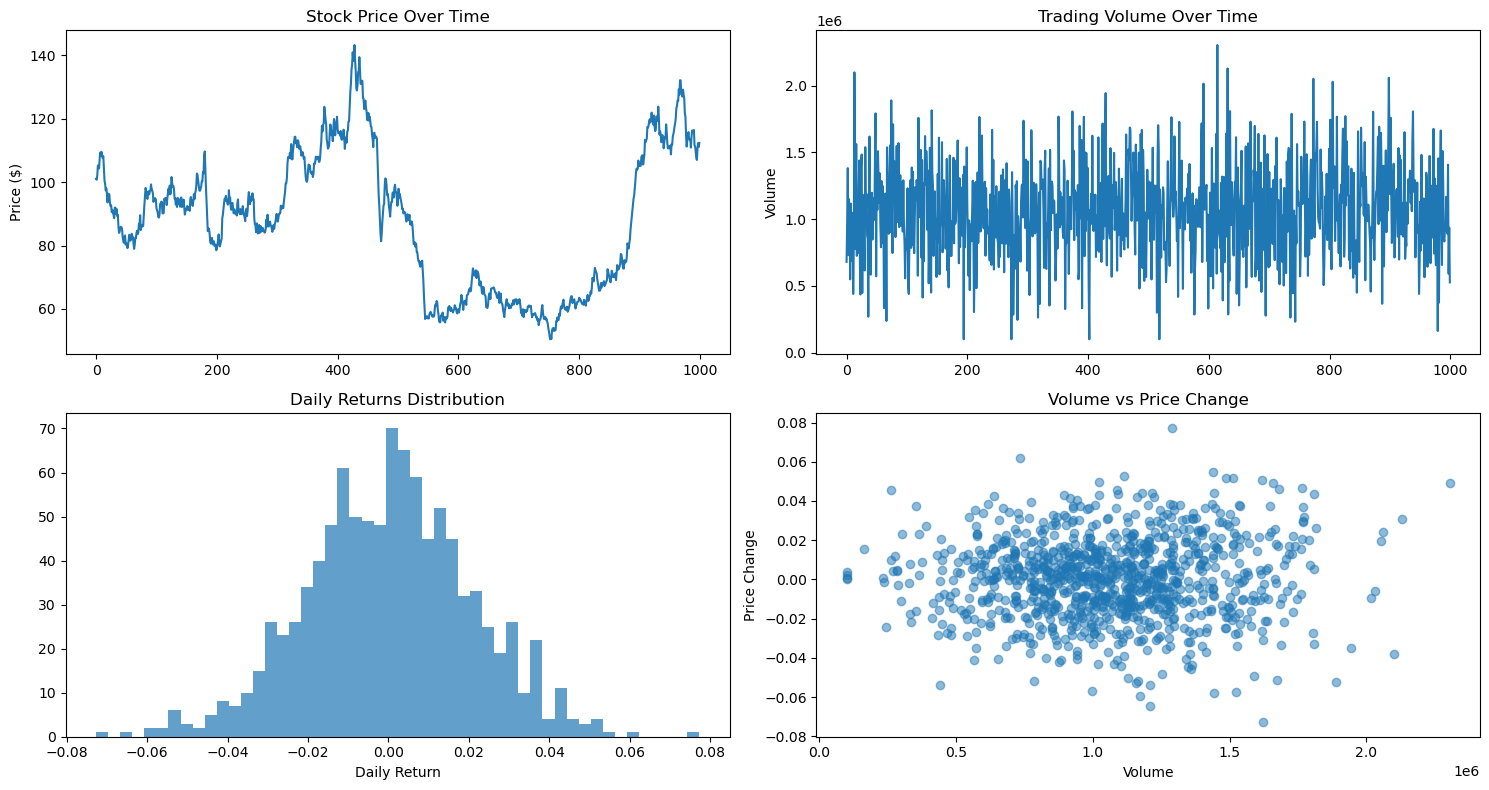

In [11]:
# Quick visualization of the generated data
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(stock_data.index, stock_data['Close'])
plt.title('Stock Price Over Time')
plt.ylabel('Price ($)')

plt.subplot(2, 2, 2)
plt.plot(stock_data.index, stock_data['Volume'])
plt.title('Trading Volume Over Time')
plt.ylabel('Volume')

plt.subplot(2, 2, 3)
plt.hist(stock_data['Close'].pct_change().dropna(), bins=50, alpha=0.7)
plt.title('Daily Returns Distribution')
plt.xlabel('Daily Return')

plt.subplot(2, 2, 4)
plt.scatter(stock_data['Volume'], stock_data['Close'].pct_change(), alpha=0.5)
plt.title('Volume vs Price Change')
plt.xlabel('Volume')
plt.ylabel('Price Change')

plt.tight_layout()
plt.show()

## Train the Model

Now let's train our LSTM model on the generated data.

In [23]:
import yfinance as yf
import subprocess
import sys



# Download real stock data for popular stocks
print("\nDownloading real stock data...")
symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
period = '2y'  # 2 years of data

real_stock_data = {}
for symbol in symbols:
    try:
        print(f"📈 Downloading {symbol}...")
        ticker = yf.Ticker(symbol)
        data = ticker.history(period=period)
        
        # Convert to our expected format
        stock_df = pd.DataFrame({
            'Date': data.index,
            'Open': data['Open'].values,
            'High': data['High'].values,
            'Low': data['Low'].values,
            'Close': data['Close'].values,
            'Volume': data['Volume'].values.astype(int),
            'Symbol': symbol
        })
        stock_df.reset_index(drop=True, inplace=True)
        real_stock_data[symbol] = stock_df
        
        print(f"✅ {symbol}: {len(stock_df)} days, Price range: ${stock_df['Close'].min():.2f} - ${stock_df['Close'].max():.2f}")
        
    except Exception as e:
        print(f"❌ Error downloading {symbol}: {e}")

print(f"\n🎯 Successfully downloaded data for {len(real_stock_data)} stocks")

# Test with Apple (AAPL) stock
if 'AAPL' in real_stock_data:
    aapl_data = real_stock_data['AAPL']
    print(f"\n📊 Training model on Apple (AAPL) stock data...")
    print(f"Data period: {aapl_data['Date'].iloc[0].date()} to {aapl_data['Date'].iloc[-1].date()}")
    
    # Create a new predictor for real data
    real_predictor = StockPricePredictor(lookback_days=60, prediction_days=7)
    
    # Train on real AAPL data
    print("🚀 Training on real Apple stock data...")
    real_history, real_metrics = real_predictor.train_model(aapl_data, train_split=0.8)


📈 Downloading AAPL...
❌ Error downloading AAPL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading MSFT...
❌ Error downloading AAPL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading MSFT...
❌ Error downloading MSFT: Too Many Requests. Rate limited. Try after a while.
📈 Downloading GOOGL...
❌ Error downloading MSFT: Too Many Requests. Rate limited. Try after a while.
📈 Downloading GOOGL...
❌ Error downloading GOOGL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading TSLA...
❌ Error downloading GOOGL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading TSLA...
❌ Error downloading TSLA: Too Many Requests. Rate limited. Try after a while.
📈 Downloading NVDA...
❌ Error downloading TSLA: Too Many Requests. Rate limited. Try after a while.
📈 Downloading NVDA...
❌ Error downloading NVDA: Too Many Requests. Rate limited. Try after a while.

🎯 Successfully downloaded data for 0 stocks
❌ Error downloading NVDA: Too Many Requests. Rate 

In [ ]:
# Train on real AAPL data
    print("🚀 Training on real Apple stock data...")
    real_history, real_metrics = real_predictor.train_model(aapl_data, train_split=0.8)

In [24]:
import yfinance as yf

# Let's try downloading other popular stocks with error handling

print("🔄 Attempting to download additional stock data...")

# Extended list of popular stocks
extended_symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'AMZN', 'META', 'NFLX', 'AMD', 'INTC']
period = '2y'  # 2 years of data

real_stock_data = {}
successful_downloads = 0

for symbol in extended_symbols:
    try:
        print(f"📈 Downloading {symbol}...")
        ticker = yf.Ticker(symbol)
        data = ticker.history(period=period)
        
        if len(data) > 0:
            # Convert to our expected format
            stock_df = pd.DataFrame({
                'Date': data.index,
                'Open': data['Open'].values,
                'High': data['High'].values,
                'Low': data['Low'].values,
                'Close': data['Close'].values,
                'Volume': data['Volume'].values.astype(int),
                'Symbol': symbol
            })
            stock_df.reset_index(drop=True, inplace=True)
            real_stock_data[symbol] = stock_df
            successful_downloads += 1
            
            print(f"✅ {symbol}: {len(stock_df)} days, Price range: ${stock_df['Close'].min():.2f} - ${stock_df['Close'].max():.2f}")
        else:
            print(f"⚠️ {symbol}: No data returned")
            
    except Exception as e:
        print(f"❌ Error downloading {symbol}: {e}")

print(f"\n🎯 Successfully downloaded data for {successful_downloads} stocks: {list(real_stock_data.keys())}")

# If we have any successful downloads, let's visualize one
if real_stock_data:
    # Pick the first available stock
    first_stock = list(real_stock_data.keys())[0]
    sample_data = real_stock_data[first_stock]
    
    print(f"\n📊 Sample data from {first_stock}:")
    print(sample_data.head())
    
    # Quick visualization
    plt.figure(figsize=(12, 6))
    plt.plot(sample_data.index, sample_data['Close'])
    plt.title(f'{first_stock} Stock Price - Last 2 Years')
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("⚠️ No stock data was successfully downloaded. Using synthetic data instead.")

🔄 Attempting to download additional stock data...
📈 Downloading AAPL...
❌ Error downloading AAPL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading MSFT...
❌ Error downloading AAPL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading MSFT...
❌ Error downloading MSFT: Too Many Requests. Rate limited. Try after a while.
📈 Downloading GOOGL...
❌ Error downloading MSFT: Too Many Requests. Rate limited. Try after a while.
📈 Downloading GOOGL...
❌ Error downloading GOOGL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading TSLA...
❌ Error downloading GOOGL: Too Many Requests. Rate limited. Try after a while.
📈 Downloading TSLA...
❌ Error downloading TSLA: Too Many Requests. Rate limited. Try after a while.
📈 Downloading NVDA...
❌ Error downloading TSLA: Too Many Requests. Rate limited. Try after a while.
📈 Downloading NVDA...
❌ Error downloading NVDA: Too Many Requests. Rate limited. Try after a while.
📈 Downloading AMZN...
❌ Error downloading NVDA

In [15]:
# Train the model
print("Training stock price prediction model...")
history, metrics = predictor.train_model(stock_data, train_split=0.8)

Training stock price prediction model...
Preparing data and calculating technical indicators...
Training PyTorch LSTM model with 700 samples...
Epoch [10/250], Train Loss: 1109.5532, Val Loss: 1569.5685
Epoch [10/250], Train Loss: 1109.5532, Val Loss: 1569.5685
Epoch [20/250], Train Loss: 510.3612, Val Loss: 657.8289
Epoch [20/250], Train Loss: 510.3612, Val Loss: 657.8289
Epoch [30/250], Train Loss: 533.3804, Val Loss: 656.9147
Epoch [30/250], Train Loss: 533.3804, Val Loss: 656.9147
Epoch [40/250], Train Loss: 528.5826, Val Loss: 650.5748
Epoch [40/250], Train Loss: 528.5826, Val Loss: 650.5748
Epoch [50/250], Train Loss: 527.9928, Val Loss: 665.3244
Epoch [50/250], Train Loss: 527.9928, Val Loss: 665.3244
Epoch [60/250], Train Loss: 514.1506, Val Loss: 661.7527
Epoch [60/250], Train Loss: 514.1506, Val Loss: 661.7527
Epoch [70/250], Train Loss: 506.5524, Val Loss: 668.2744
Epoch [70/250], Train Loss: 506.5524, Val Loss: 668.2744
Epoch [80/250], Train Loss: 518.6512, Val Loss: 655.88

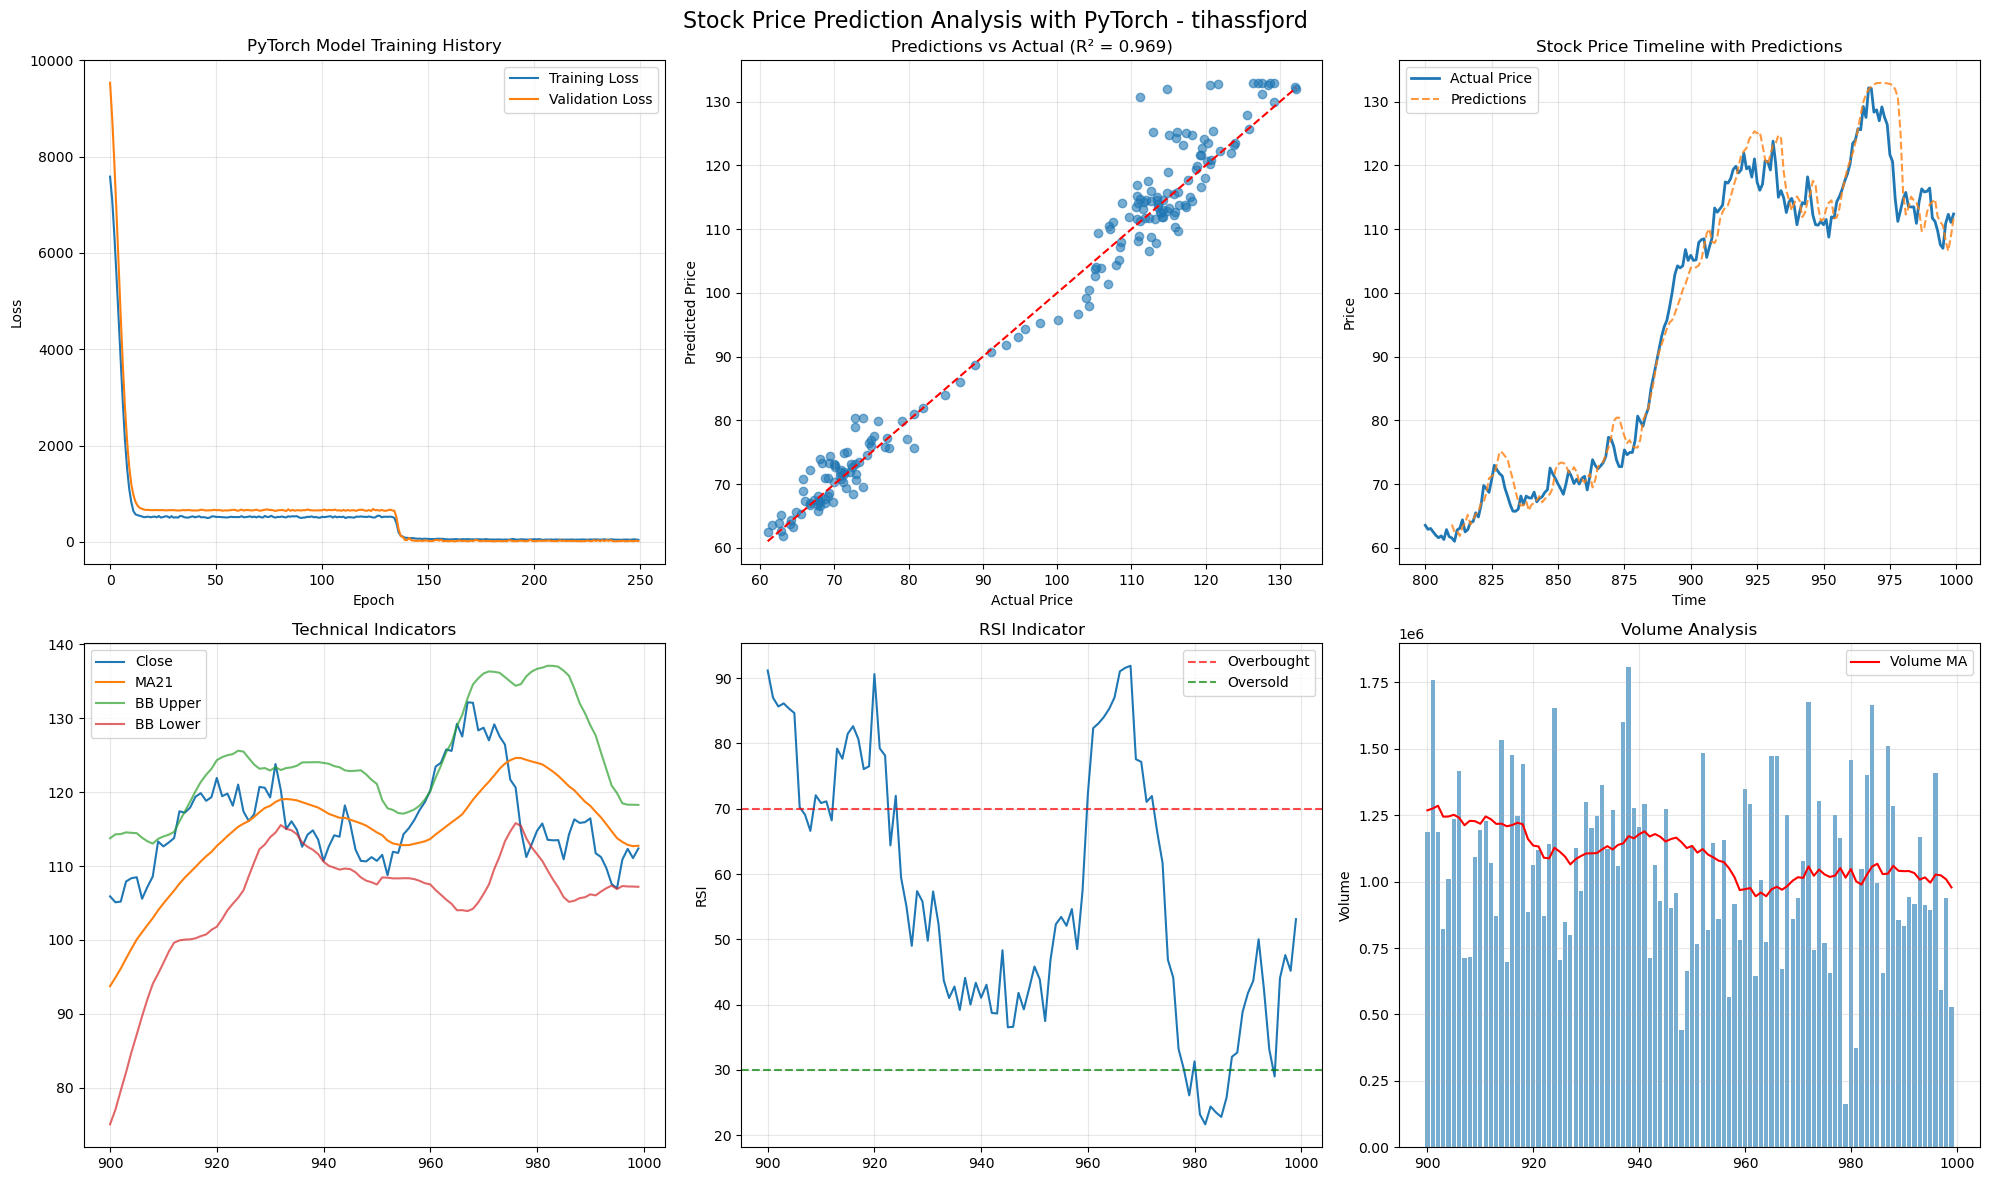


STOCK PRICE PREDICTION PERFORMANCE SUMMARY (PyTorch)
Model Type: PyTorch LSTM Neural Network
Training R²: 0.9834
Testing R²: 0.9687
Training MSE: 8.0035
Testing MSE: 15.8054
Training MAE: 2.1893
Testing MAE: 2.7750

Future Price Predictions (Next 7 Days):
Day 1: $112.75
Day 2: $129.86
Day 3: $132.66
Day 4: $133.27
Day 5: $133.46
Day 6: $133.53
Day 7: $133.56


In [16]:
# Visualize comprehensive results
predictor.plot_results(stock_data, history, metrics)

## Make Future Predictions

Let's predict stock prices for the next few days.

Predicting stock prices for the next 7 days...

📈 Predicted prices for next 7 days:
Day 1: $112.75
Day 2: $129.86
Day 3: $132.66
Day 4: $133.27
Day 5: $133.46
Day 6: $133.53
Day 7: $133.56


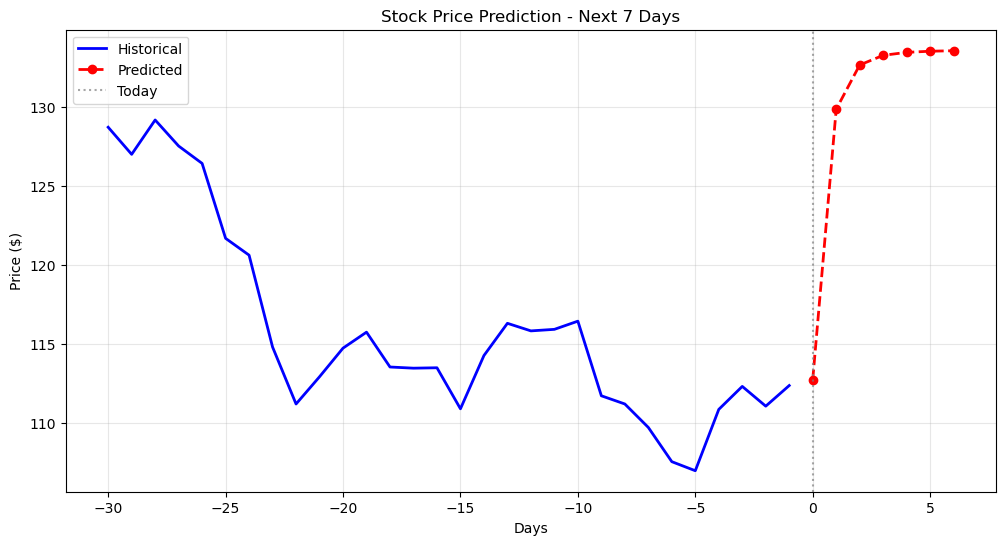

In [17]:
# Predict future prices
prediction_days = 7
print(f"Predicting stock prices for the next {prediction_days} days...")

try:
    future_predictions = predictor.predict_future_prices(stock_data, days=prediction_days)
    
    print(f"\n📈 Predicted prices for next {prediction_days} days:")
    for i, price in enumerate(future_predictions, 1):
        print(f"Day {i}: ${price:.2f}")
    
    # Visualize predictions
    plt.figure(figsize=(12, 6))
    
    # Show last 30 days of actual data
    last_30_days = stock_data['Close'].tail(30)
    plt.plot(range(-30, 0), last_30_days.values, 'b-', label='Historical', linewidth=2)
    
    # Show predictions
    plt.plot(range(0, prediction_days), future_predictions, 'r--', 
             label='Predicted', linewidth=2, marker='o')
    
    plt.axvline(x=0, color='gray', linestyle=':', alpha=0.7, label='Today')
    plt.title(f'Stock Price Prediction - Next {prediction_days} Days')
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"❌ Error making predictions: {e}")

## Technical Analysis

Let's examine the technical indicators for our stock data.

In [18]:
# Calculate and display technical indicators
data_with_indicators = predictor.calculate_technical_indicators(stock_data)
latest = data_with_indicators.iloc[-1]

print("🔍 Latest Technical Analysis:")
print(f"Current Price: ${latest['Close']:.2f}")
print(f"RSI: {latest['RSI']:.1f} ({'Overbought' if latest['RSI'] > 70 else 'Oversold' if latest['RSI'] < 30 else 'Neutral'})")
print(f"MACD: {latest['MACD']:.3f}")
print(f"Bollinger Band Position: {latest['BB_Position']:.2f}")
print(f"Volume Ratio: {latest['Volume_Ratio']:.2f}")
print(f"7-day Price Change: {latest['Price_Change_7d']:.1%}")

# Display technical indicators dataframe
print("\nTechnical Indicators (last 5 days):")
print(data_with_indicators[['Close', 'RSI', 'MACD', 'BB_Position', 'Volume_Ratio']].tail())

🔍 Latest Technical Analysis:
Current Price: $112.38
RSI: 53.1 (Neutral)
MACD: -2.130
Bollinger Band Position: 0.47
Volume Ratio: 0.54
7-day Price Change: 1.1%

Technical Indicators (last 5 days):
          Close        RSI      MACD  BB_Position  Volume_Ratio
995  106.995048  28.993001 -2.831801     0.007740      0.894771
996  110.874018  44.049548 -2.711413     0.319566      1.372246
997  112.328336  47.588489 -2.470179     0.460034      0.578158
998  111.078843  45.169444 -2.352703     0.347915      0.928750
999  112.384203  53.086004 -2.129720     0.468278      0.538257


## Interactive Experimentation

You can now experiment with different parameters and scenarios. Here are some ideas:

1. **Try different lookback periods**: Change `lookback_days` parameter
2. **Experiment with data size**: Generate different amounts of synthetic data
3. **Test different symbols**: Generate data for different stock symbols
4. **Modify technical indicators**: Add new indicators or modify existing ones
5. **Adjust model architecture**: If using LSTM, try different layer configurations

Use the cells below for your experiments!

In [ ]:
# Experiment cell 1: Try different parameters
# Example: Create predictor with different lookback period
experimental_predictor = StockPricePredictor(lookback_days=30, prediction_days=14)
print("Created experimental predictor with 30-day lookback and 14-day predictions")

# You can test it here...

In [ ]:
# Experiment cell 2: Generate different stock data
# Example: Create data for a more volatile stock
volatile_stock = predictor.generate_synthetic_stock_data(days=500, symbol="VOLATILE")
print(f"Generated volatile stock data with {len(volatile_stock)} days")

# Visualize the difference
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[:500], stock_data['Close'][:500], label='Original TECH', alpha=0.7)
plt.plot(volatile_stock.index, volatile_stock['Close'], label='VOLATILE', alpha=0.7)
plt.title('Comparison of Different Stock Patterns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Experiment cell 3: Your custom experiments
# Use this cell for your own testing and modifications

# Example ideas:
# 1. Test model performance on different data sizes
# 2. Compare predictions with different lookback periods
# 3. Analyze correlation between technical indicators and predictions
# 4. Create ensemble predictions using multiple models

print("This cell is ready for your custom experiments!")